Index(['Bangwe_Organic_1', 'Bangwe_Organic_2', 'Bangwe_inorganic_1',
       'Bangwe_inorganic_2', 'BCA_Organic_1', 'BCA_Organic_2',
       'BCA_inorganic_1', 'BCA_inorganic_2', 'Naizi_Organic_1',
       'Naizi_Organic_2', 'Naizi_inorganic_1', 'Naizi_inorganic_2',
       'Chigumula_Organic_1', 'Chigumula_Organic_2', 'Chigumula_inorganic_1',
       'Chigumula_inorganic_2'],
      dtype='object')


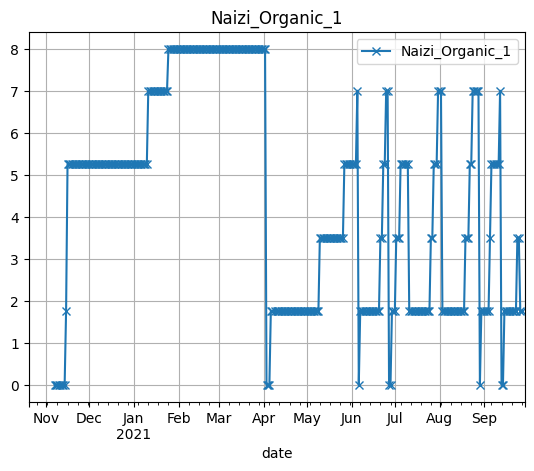

In [132]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#plt.rcParams["figure.figsize"] = [7.50, 3.50]
#plt.rcParams["figure.autolayout"] = True

#Extract CSV filling data
skip_filling_df = pd.read_csv('../../data/raw_data/Skip-fullness-blantyre-raw.csv')

#Setting the index of the dataframe to the date and convert to datetime
skip_filling_df.set_index('date', inplace=True)
skip_filling_df.index = pd.to_datetime(skip_filling_df.index)

#List of the skips
skip_dfCol = skip_filling_df.columns

#Remove '.' and NaN values and convert to float
skip_filling_df = skip_filling_df.replace('.', np.nan)
skip_filling_df.dropna(axis=1, how='all', inplace=True)
skip_filling_df = skip_filling_df.astype(float)

numCol = len(skip_dfCol)

print(skip_dfCol)

type = 2
binNum = 8

totY = 4
totX = 4
if type == 1:
    #print(skip_filling_df.columns)
    figure, axis = plt.subplots(totX, totY)
    for i in range(totX):
        for j in range(totY):
            if j+4*i >= numCol:
                break
            skip_filling_df.plot(ax=axis[i, j], use_index=True, y=skip_dfCol[j + 4 * i], grid=True, marker='x')
            # doesn't show missing data i.e. long straight values are as such in raw data
            axis[i, j].set_title(skip_filling_df.columns[j + 4 * i])
            axis[i, j].set_yticks([0,2,4,6,8])
            axis[i, j].get_legend().remove()
    plt.show()
elif type == 2:
    skip_filling_df.plot(use_index=True, y=skip_dfCol[binNum], grid=True, marker='x')
    plt.title(skip_filling_df.columns[binNum])

skip_filling_true = skip_filling_df.copy()
skip_filling_true[skip_filling_true < 8] *= 4 / 7
skip_filling_true[skip_filling_true == 8] = 5


date
2020-10-20    False
2020-10-21    False
2020-10-22    False
2020-10-23    False
2020-10-24    False
              ...  
2021-09-25    False
2021-09-26    False
2021-09-27    False
2021-09-28    False
2021-09-29    False
Name: Chigumula_Organic_2, Length: 345, dtype: bool
date
2021-02-01    True
2021-02-06    True
2021-03-24    True
2021-04-02    True
2021-05-02    True
2021-05-14    True
2021-05-18    True
2021-05-20    True
2021-05-30    True
2021-06-08    True
2021-06-16    True
2021-07-02    True
2021-07-16    True
2021-07-24    True
2021-07-31    True
2021-08-14    True
2021-08-24    True
2021-09-05    True
Name: Chigumula_Organic_2, dtype: bool


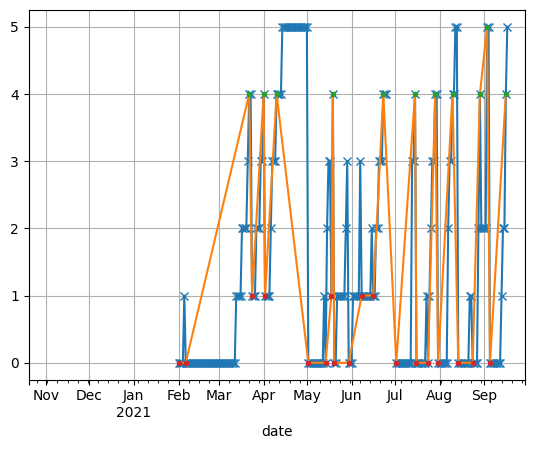

In [108]:
skip_filling_interest = skip_filling_true[skip_dfCol[binNum]].copy()
#print(skip_filling_interest)


#print(skip_filling_df)
diff_pos = skip_filling_interest.diff() #difference val(n) - val(n-1)
diff_neg = skip_filling_interest.diff(periods=-1) #difference val(n) - val(n+1)

#number assignments
fives = (skip_filling_interest == 5)
fours = (skip_filling_interest == 4)
ones = (skip_filling_interest == 1)
zeros = (skip_filling_interest == 0)

#Fetches first available top values of each ramp
topvals_4 = fours*(diff_pos != 0) #four where previous value is not a four
topvals_5 = fives*(diff_pos !=0) * (diff_pos!=1) #fives where previous value is neither a five nor a four

#Fetches first available bottom values
bottomvals_0 = zeros*(diff_pos != 0) #zeros where the previous value is not a zero
bottomvals_1 = ones*(diff_pos != 0) *  (diff_pos != 1) # * (diff_neg != 1) 
#Ones where previous value neither 1 or 0; comment --> (next value not 1)




#Aggregate bottomvals & topvals separately and only keep true value indices
bottomvals = bottomvals_0+bottomvals_1
print(bottomvals)
bottomvals = bottomvals[bottomvals]
print(bottomvals)
topvals = topvals_5+topvals_4
topvals = topvals[topvals]


#Multiply with the value of the bottom/topval
bottomvals = bottomvals * skip_filling_interest
topvals = topvals * skip_filling_interest


mainvals = pd.concat([bottomvals.dropna(), topvals.dropna()]).sort_index().to_frame()
# fig, ax = plt.subplots()
# mainvals.plot(use_index=True,grid=True,ax=ax, kind='line')
mainvals.columns = ['values']
mainvals['diff'] = mainvals['values'].diff()
# mainvals = mainvals.drop(mainvals[(mainvals['diff'] < 3) & (mainvals['diff'] > 0)].index)

# mainvals['diff'] = mainvals['values'].diff()
# mainvals = mainvals.drop(mainvals[(mainvals['diff'] < 3) & (mainvals['diff'] > 0)].index)

mainvals['timediff'] = mainvals.index.to_series().diff()
firstrow = mainvals.first('1D')
mainvals = mainvals.dropna()
mainvals = pd.concat([firstrow, mainvals]).sort_index()
mainvals['der'] = mainvals['diff']/mainvals['timediff'].dt.days

#print(mainvals)
#return mainvals, bottomvals,topvals
#print(skip_filling_df.columns)


fig, ax = plt.subplots()
#mainvals, bottomvals, topvals = detectDrop()
increase = mainvals[(mainvals['der']>0)]
increasemean = increase['der'].mean()
#print(increase)
#print(increasemean)
# mainvals =pd.concat([bottomvals.dropna(),topvals.dropna()]).sort_index()
skip_filling_interest.plot(use_index=True, marker='x',grid=True,ax=ax, kind='line')
#topvals.plot(use_index=True,grid=True,ax=ax, style='.')
mainvals['values'].plot(use_index=True,grid=True,ax=ax, kind='line')
topvals.plot(use_index=True,grid=True,ax=ax, style='.')
bottomvals.plot(use_index=True,grid=True,ax=ax, style='.')

#print(skip_filling_df.columns[binNum])
# increase.to_csv('csvs/'+skip_filling_df.columns[binNum]+'.csv')
# plt.savefig('figures/'+skip_filling_df.columns[binNum]+'png')
plt.show()
# plt.close('all')

<AxesSubplot: xlabel='date'>

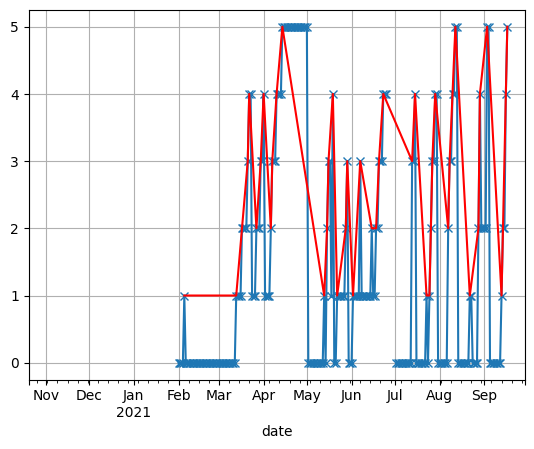

In [134]:
# skip_filling_interest = skip_filling_true[skip_dfCol[binNum]].copy()
diff_pos = skip_filling_interest.diff() #difference val(n) - val(n-1)
diff_neg = skip_filling_interest.diff(periods=-1) #difference val(n) - val(n+1)
top_diff_vals = skip_filling_interest[(diff_pos > 0)]

diff_neg2 = top_diff_vals.copy().diff(periods=-1)
top_diff_vals2 = top_diff_vals[diff_neg >= 0]

#print(top_diff_vals)
fig, ax = plt.subplots()
skip_filling_interest.plot(use_index=True, marker='x',grid=True,ax=ax, kind='line')
top_diff_vals.plot(use_index=True,grid=True,ax=ax,style='-', color='red')
#top_diff_vals2.plot(use_index=True,grid=True,ax=ax,style='.', color='blue')
#top_diff_vals2.plot(use_index=True,grid=True,ax=ax,style='.')